[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Plant Classification-Interpolation Methods-1

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will reply you as soon as possible.

## Background

In many Computer Vision applications, digital images must be rescaled to smaller or, more rarely, larger dimensions. This is particularly common in applications involving Convolutional Neural Networks, where we need to downsample an image to a small rectangle so it can fit through its input window - this box may usually be around 128x128 or 224x224 pixels.

When upsampling an image to a higher resolution, this process is called as **Interpolation**, whereas when downsampling to a lower resolution it is called Decimation. Even though we will be giving more attention to the downscaling process, we shall be referring to it as interpolating, for simplicity's sake. Advanced theory on Interpolation & Decimation can be found in **[Computer vision: algorithms and applications, (2021)](https://szeliski.org/Book/)**. 

In this notebook we shall examine the various interpolation methods offered in the **OpenCV library**, both from a visual standpoint as well as performance-wise. The goal is to find, if possible, which method provides the best and fastest downscaling, and investigate what parameters can affect them and to what degree.

OpenCV provides the following Interpolation methods:
- **Nearest Neighbor:** Assigns the value of the nearest pixel to the pixel in the output visualization. This is the fastest interpolation method but the resulting image may contain jagged edges.
- **Bilinear:** Surveys the 4 closest pixels, creates a weighted average based on the nearness and brightness of the surveyed pixels and assigns that value to the pixel in the output image.
- **Bicubic:** Yields substantially better results, with an increase in computational cost - can be regarded as a computationally efficient approximation to Lanczos resampling.
- **Area Relation:** Resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire'-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method. 
- **Lanczos:** It maps each sample of the given signal to a translated and scaled copy of the Lanczos kernel, which is a sinc function windowed by the central lobe of a second, longer, sinc function. The sum of these translated and scaled kernels is then evaluated at the desired points.
- **BitExact Bilinear:** Not much information could be found on this method.
- **BitExact Nearest Neighbor:** This will produce same results as the nearest neighbor method in PIL, scikit-image or Matlab. 

### Library Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
import time
import sys
import os
from os import walk
from pathlib import Path
from tqdm import tqdm

random.seed(747)
%matplotlib inline

### Dataset Loading

In [2]:
# Retrieve all image filenames from the specified datasets

DATASETS = ['Tomato-240519-Healthy-zz-V1-20210225103740',
            'Black nightsade-220519-Weed-zz-V1-20210225102034',
            'Broccoli-011120-Plasmodiophora brassicae (clubroot)-zz-V1-20210225102059']

FILE_EXTENSIONS = ("jpg","bmp","png")

# Get paths to the datasets
data_paths = [str(Path(Path.cwd()).parents[1].joinpath('eden_library_datasets/').joinpath(dataset_name)) for dataset_name in DATASETS]

image_files = []
for path in data_paths:
    _, _, filenames = next(walk(path)) # Get filenames in each path
    for x in filenames:
        if x.lower().endswith(FILE_EXTENSIONS): # Keep only imagefiles
            image_files.extend([path + os.path.sep + x])

print(len(image_files), 'files found')

338 files found


### Visual comparison of interpolation methods

In [3]:
# Gather all OpenCV interpolation methods in a dictionary for easy recall during testing

interpol_names = ["Nearest Neighbor", "Bilinear", "Bicubic", "Area Relation", "Lanczos", "BitExact Bilinear", "BitExact Nearest Neighbor"]
interpol_methods = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4, cv2.INTER_LINEAR_EXACT, cv2.INTER_NEAREST_EXACT]
interpol_dict = dict(zip(interpol_names, interpol_methods))

In [4]:
def resize_array(im_original, interpolation, im_size):
    '''
    First resizes to smaller resolution of given dimensions, and then back to the original using the same interpolation method.

            Parameters:
                    im_original (np.array): Original image array to be resized
                    interpolation (int): OpenCV interpolation method
                    im_size (int tuple): Tuple of dimensions to resize to

            Returns:
                    im_up_sized (np.array): Interpolated image array
    '''
    im_down_sized = cv2.resize(im_original, im_size, interpolation=interpolation) # Downscale original image to small resolution
    im_up_sized = cv2.resize(im_down_sized, (im_original.shape[1], im_original.shape[0]), interpolation=interpolation) # Upscale downscaled image to initial dimensions
    return im_up_sized


def interpolate_image(inter_method, im_file, im_size):
    '''
    Loads image from given filename, checks dimensions for scaling while maintaining aspect ratio, 
    calls method to resize image using specified OpenCV interpolation methods.

            Parameters:
                    inter_method (int): OpenCV interpolation method
                    im_file (str): Image filename string
                    im_size (int tuple): Tuple of dimensions to resize to

            Returns:
                    im_original/im_resized (np.array): Original or interpolated image array
    '''
    im_initial = cv2.imread(im_file)
    im_initial = cv2.cvtColor(im_initial, cv2.COLOR_BGR2RGB)
    height_in, width_in, channel_in = im_initial.shape # Get dimensions of original image
    largest_dim = max(im_initial.shape) # Get largest dimension of original image
    
    # Based on https://stackoverflow.com/a/59698237
    new_width = new_height = largest_dim # Set dimensions of base image
    im_original = np.full((new_width, new_height, channel_in), (0,0,0), dtype=np.uint8) # Create new base image for padding
    x_off = (largest_dim - width_in) // 2 # X-axis offset
    y_off = (largest_dim - height_in) // 2 # Y-axis offset
    im_original[y_off:y_off+height_in, x_off:x_off+width_in] = im_initial # Copy original image into center of base image
    
    # If no interpolation method specified, return padded original image
    if inter_method is None:
        return im_original
    else:
        im_resized = resize_array(im_original, inter_method, im_size)
        return im_resized

In [5]:
def add_subplot(image_array, position, title, fig, num_samples):
    '''
    Places displayed image in a subplot position of the given figure.

            Parameters:
                    image_array (np.array): Image array to be displayed in subplot
                    position (int): Subplot position in main plot
                    title (str): String to use as subplot title
                    fig (plt.figure): Figure to plot in
                    num_samples (int): Number of sample images - used to scale plot
    '''
    fig.add_subplot(2*num_samples, 8, position)
    plt.imshow(image_array)
    plt.axis('off')
    plt.title(title)
    

def plot_images(im_size, num_samples):
    '''
    Plots the 7 interpolated images in a single plot. 
    Interpolation methods and diffs from the original image are shown in columns, separate image files are shown in rows.
    
            Parameters:
                    im_size (int tuple): Tuple of dimensions to resize to
                    num_samples (int): Number of sample images to examine
    '''
    # Plotting may take some time as the final plot has large dimensions
    fig = plt.figure(figsize=(16*num_samples, 9*num_samples))

    # Run all interpolation methods for each random sample
    for row, im_file in enumerate(tqdm(random.sample(image_files, num_samples))):
        try:
            im_original = interpolate_image(None, im_file, im_size)
        except:
            print("Selected file is not an image.")
            next
        
        # Display original image in first position
        add_subplot(im_original, 2*row*8+1, "Original: " + im_file.split("/")[-1], fig, num_samples)
        
        # Run each sample through all interpolation methods
        for i, interpol in enumerate(interpol_dict.keys()):
            im_resized = interpolate_image(interpol_dict[interpol], im_file, im_size)
            add_subplot(im_resized, 2*row*8+2+i, interpol, fig, num_samples) # Display interpolated images in first row
            add_subplot(cv2.absdiff(im_resized, im_original), 2*row*8+10+i, interpol + " vs Original", fig, num_samples) # Display diffs in second row

    fig.tight_layout()
    plt.show()

100%|██████████| 3/3 [00:20<00:00,  6.68s/it]


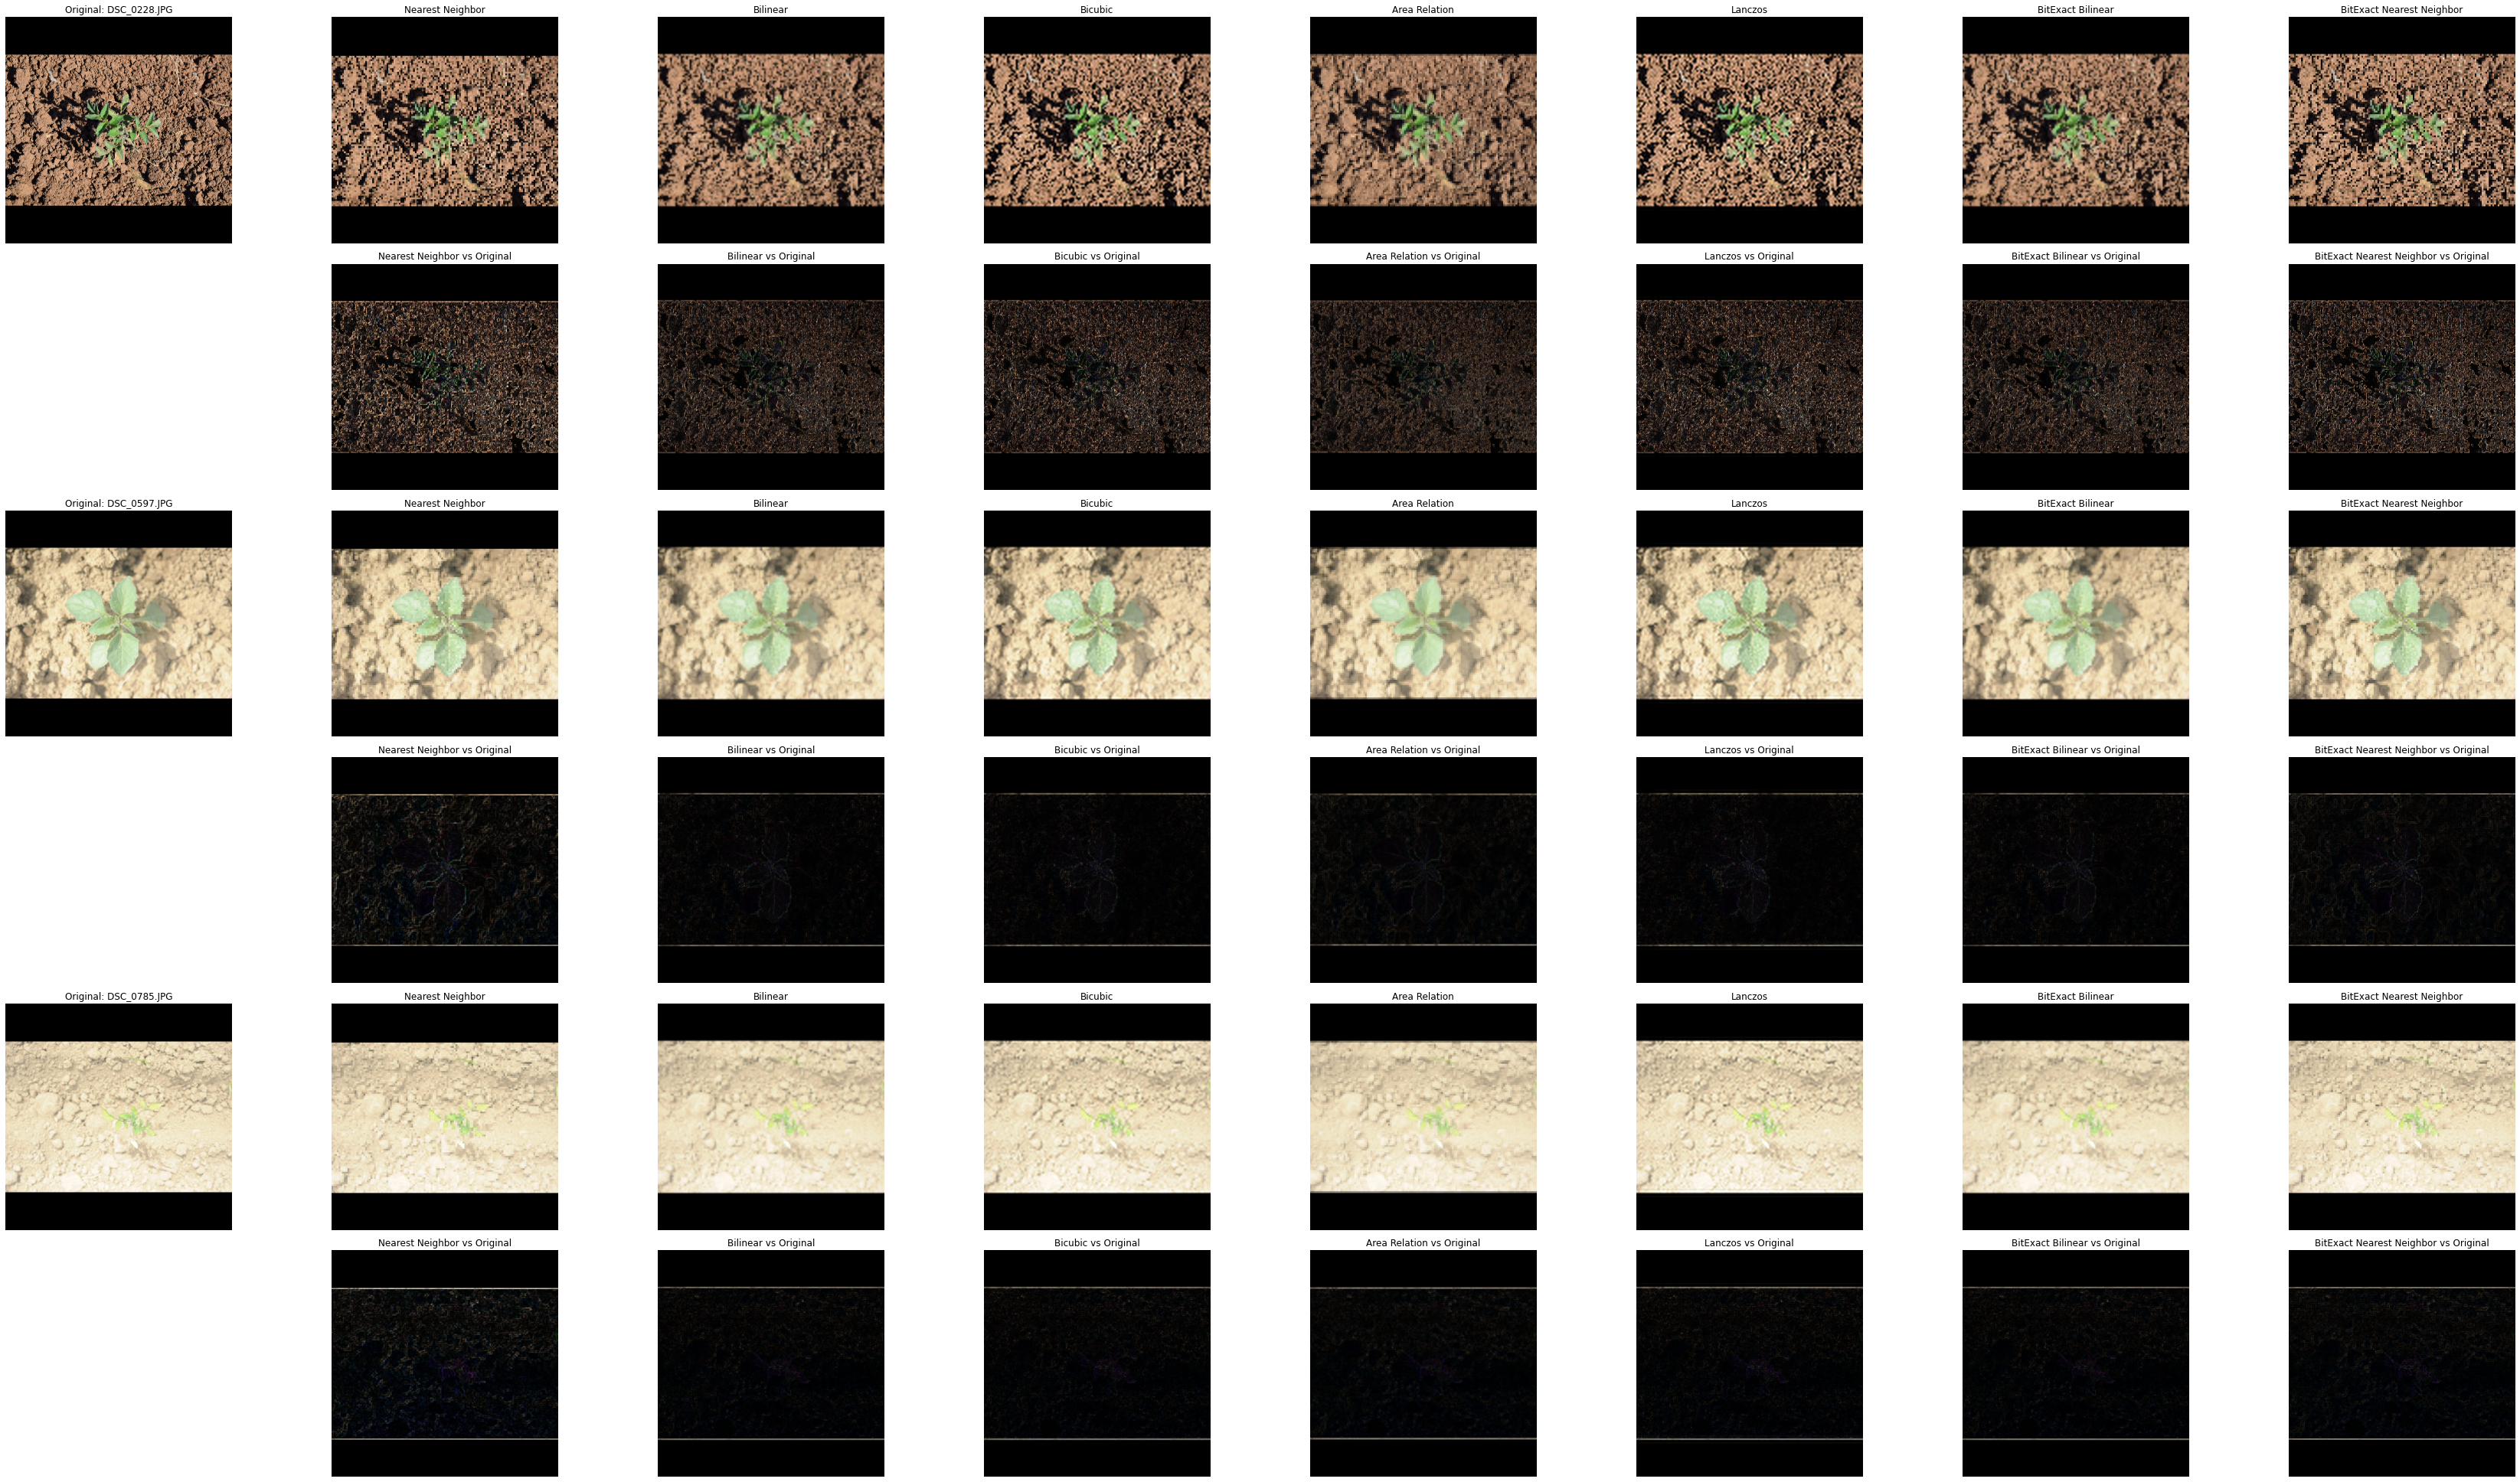

In [6]:
plot_images((128, 128), num_samples=3)

As can be seen in the above images, the various interpolation methods offer slightly differing visual results, which will certainly diverge when downscaling to even smaller resolutions. The differences can be perceived as increased blurring, sharpening, or pixelating compared to the original image (1st row/1st position).

In the alternating rows the difference between the interpolated and original arrays is displayed (without normalization) so one can visually assess the effect the various interpolation methods have on the original image. One can see that the effect is most pronounced on the edges of regions, either of fore- and background objects, or patterns.

### Performance comparison of Interpolation methods

In [7]:
def measure_resize_performance(im_file):
    '''
    Resizes given imagefile using different pairs of interpolation methods for downscaling & upscaling to a series of different dimensions.
    Also, measures performance and loss vs. the original image array.

            Parameters:
                    im_file (str): Image filename string

            Returns:
                    df_results (pd.DataFrame): Pandas Dataframe containing all interpolation comparison data for given imagefile
    '''
    
    global df_results

    # Loop through small, medium and high resolutions for downscaling
    for im_dim in [32, 128, 512]:
        im_size = (im_dim,im_dim)
        im_original = interpolate_image(None, im_file, im_size)
        
        # Check all interpolation method combinations of down- and upscaling
        for down_scale in interpol_dict.keys():
            for up_scale in interpol_dict.keys():

                start_time = time.process_time()
                im_down_sized = cv2.resize(im_original, (im_dim, im_dim), interpolation=interpol_dict[down_scale]) # Downscale original image to small resolution
                im_up_sized = cv2.resize(im_down_sized, (im_original.shape[1], im_original.shape[0]), interpolation=interpol_dict[up_scale]) # Upscale downscaled image to initial dimensions
                end_time = time.process_time()

                distance = np.linalg.norm(im_up_sized-im_original)
                timer = end_time - start_time

                df_results = df_results.append({"down_im": down_scale, # Downscaling interpolation method
                                                "up_im": up_scale, # Upscaling interpolation method
                                                "scale_res": im_dim, # Downscaling resolution
                                                "distance": distance, # Euclidean distance between interpolated and original image
                                                "time": timer, # Time required for down- and upscaling
                                               }, ignore_index=True)
    return df_results

In [8]:
# Measure performance for each interpolation pair (down- and upscaling) for 10 sample images

num_samples = 10

df_results = pd.DataFrame(columns = ["down_im", "up_im", "scale_res", "distance", "time"]) # Dataframe to contain comparison data

for row, im_file in enumerate(tqdm(random.sample(image_files, num_samples))):
    measure_resize_performance(im_file)

df_results["scaling"] = "D: " + df_results["down_im"] + " / U: " + df_results["up_im"] # Combine down- and upscaling columns for easier plotting
df_results

100%|██████████| 10/10 [04:44<00:00, 28.47s/it]


down_im                      up_im scale_res  \
0              Nearest Neighbor           Nearest Neighbor        32   
1              Nearest Neighbor                   Bilinear        32   
2              Nearest Neighbor                    Bicubic        32   
3              Nearest Neighbor              Area Relation        32   
4              Nearest Neighbor                    Lanczos        32   
...                         ...                        ...       ...   
1465  BitExact Nearest Neighbor                    Bicubic       512   
1466  BitExact Nearest Neighbor              Area Relation       512   
1467  BitExact Nearest Neighbor                    Lanczos       512   
1468  BitExact Nearest Neighbor          BitExact Bilinear       512   
1469  BitExact Nearest Neighbor  BitExact Nearest Neighbor       512   

          distance      time  \
0     9.850084e+05  0.080501   
1     1.018404e+06  0.050911   
2     9.894064e+05  0.247536   
3     9.850084e+05  0.053768   
4     9.872205e+05  0.503642   
...            ...       ...   
1465  9.320225e+05  0.087400   
1466  9.483952e+05  0.081426   
1467  9.358776e+05  0.453585   
1468  9.281876e+05  0.103788   
1469  9.532612e+05  0.082236   

                                                scaling  
0             D: Nearest Neighbor / U: Nearest Neighbor  
1                     D: Nearest Neighbor / U: Bilinear  
2                      D: Nearest Neighbor / U: Bicubic  
3                D: Nearest Neighbor / U: Area Relation  
4                      D: Nearest Neighbor / U: Lanczos  
...                                                 ...  
1465          D: BitExact Nearest Neighbor / U: Bicubic  
1466    D: BitExact Nearest Neighbor / U: Area Relation  
1467          D: BitExact Nearest Neighbor / U: Lanczos  
1468  D: BitExact Nearest Neighbor / U: BitExact Bil...  
1469  D: BitExact Nearest Neighbor / U: BitExact Nea...  

[1470 rows x 6 columns]

### Interpolation methods performance plots

The following set of diagrams plots the Euclidean distance (we may call it loss) between the interpolated and their original arrays - lower values are better.

In the left diagram we see the loss of each down- and upscale interpolation method combination:
- Altogether, most methods performed equally well, with no significant deviations.
- Area Relation performed slightly poorer - experiments showed that for specific imagesets it performed slightly better.
- The upscaling interpolation method does not affect loss significantly, except for the (BitExact) Bilinear methods.

In the right diagram we have plotted the loss for the various downscale resolutions. Downscaling to higher resolutions obviously helps with retaining more information, but not by a large margin.

<AxesSubplot:title={'center':'distance'}, xlabel='[scale_res]'>

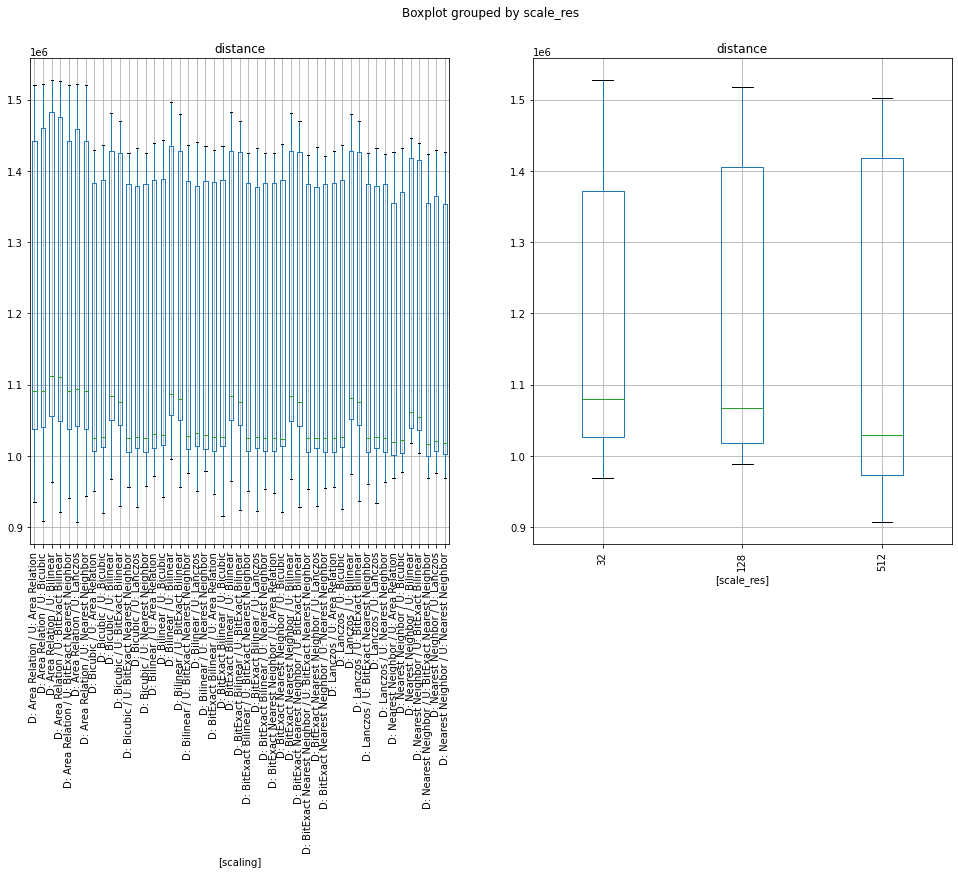

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
df_results.boxplot(column=['distance'], by=['scaling'], ax = axes[0], rot=90)
df_results.boxplot(column=['distance'], by=['scale_res'], ax = axes[1], rot=90)

The following set of diagrams plots the processing time required to resize the original arrays, using the various interpolation methods - lower values are better.

In the left diagram we see the processing time of each down- and upscale interpolation method combination:
- Most interpolation methods performed equally well.
- Area Relation performed badly for downscaling, as did Bicubic and Lanczos for upscaling.

In the right diagram is displayed the processing time for the various downscale resolutions. Downscaling takes about the same time for the tested resolutions.

<AxesSubplot:title={'center':'time'}, xlabel='[scale_res]'>

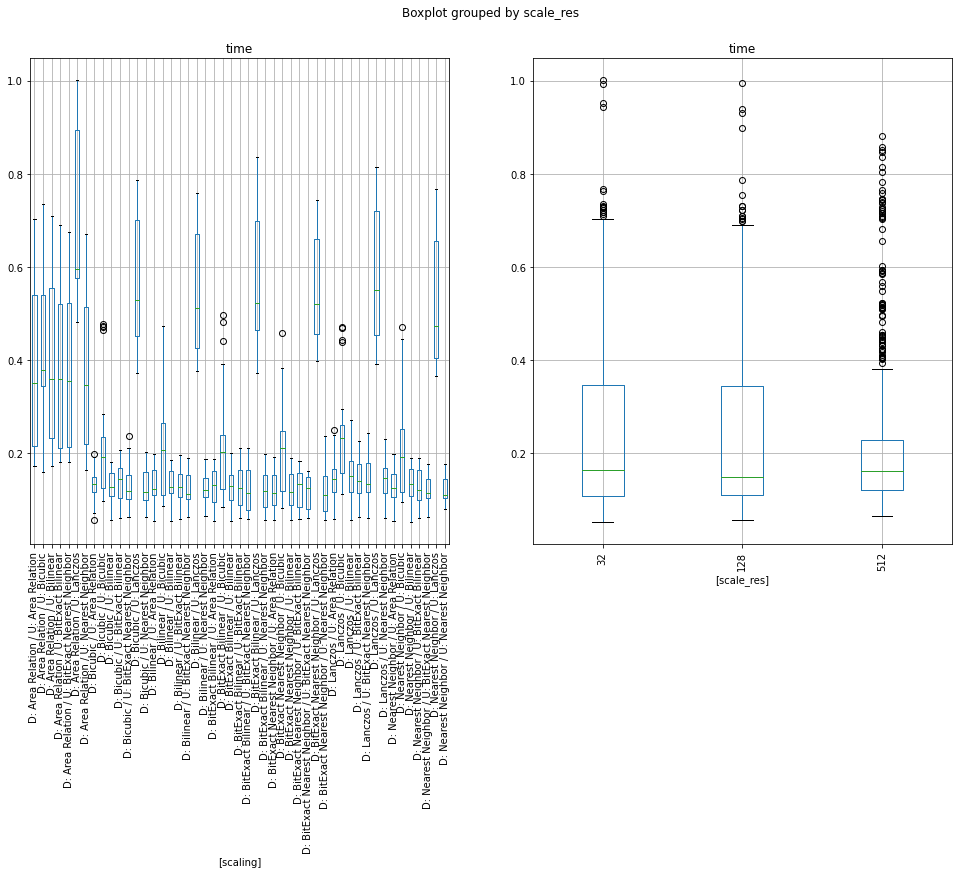

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
df_results.boxplot(column=['time'], by=['scaling'], ax = axes[0], rot=90)
df_results.boxplot(column=['time'], by=['scale_res'], ax = axes[1], rot=90)

### Conclusions
From the above we can conclude that no single interpolation method is the best. 

All are lossy techniques, and our selection would have to take into account the algorithm performance, the acceptable level of information loss, the downscaling resolution required, the visual artifacts, as well as the nature of the image dataset itself.

### Possible Extensions
1. Visually compare interpolation methods for smaller/larger downscale resolutions
2. Visually compare interpolation methods for low contrast or blurry images
3. Compare interpolation methods performance on different imagesets (singular or multiple)
4. Use different loss metric for comparison, e.g. Minkowski distance of order other than 2
5. Examine interpolation effects when upscaling to a larger resolution than the original.

## Bibliography

Szeliski, Richard. Computer vision: algorithms and applications. Springer Science & Business Media, 2010. (https://szeliski.org/Book/)

https://docs.opencv.org/4.5.0/da/d54/group__imgproc__transform.html#ga5bb5a1fea74ea38e1a5445ca803ff121

https://en.wikipedia.org/wiki/Interpolation

https://northstar-www.dartmouth.edu/doc/idl/html_6.2/Interpolation_Methods.html

https://stackoverflow.com/questions/189943/how-can-i-quantify-difference-between-two-images#3935002

https://en.wikipedia.org/wiki/Minkowski_distance